In [1]:
import json
from urllib import parse
from urllib.request import urlopen
from PIL import Image, ImageDraw
import os, shutil
import numpy as np
import pandas as pd
import sqlite3
from matplotlib import colors, cm, pyplot as plt
from random import randint
import glob
import random

In [2]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines
PIXELS_PER_BIN = 1
MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1
MZ_PER_TILE = 18.0
MZ_BIN_WIDTH = MZ_PER_TILE / (PIXELS_X * PIXELS_PER_BIN)

In [3]:
mz_bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accommodate the maximum value
MZ_BIN_COUNT = len(mz_bins)

In [4]:
number_of_features_to_synthesise_for_charge = {2:10, 3:45}  # charge:number_to_synthesise

In [5]:
BASE_DIR = '/Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling'


In [6]:
SYNTHESISED_TILES_DIR = '{}/synthesised-tiles'.format(BASE_DIR)
TRAINING_SET_BASE_DIR = '{}/training set'.format(BASE_DIR)
TRAINING_SET_FILES_DIR = '{}/sets/train'.format(TRAINING_SET_BASE_DIR)
TRAINING_SET_BACKUP_FILES_DIR = '{}/sets/train-backup'.format(TRAINING_SET_BASE_DIR)

In [7]:
CONVERTED_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-190719_Hela_Ecoli_1to1_01-converted.sqlite'


In [8]:
if os.path.exists(SYNTHESISED_TILES_DIR):
    shutil.rmtree(SYNTHESISED_TILES_DIR)
os.makedirs(SYNTHESISED_TILES_DIR)


In [9]:
annotations_file_name = '{}/annotated tiles/via_export_json_aw.json'.format(BASE_DIR)
with open(annotations_file_name) as annotations_file:
    annotations = json.load(annotations_file)

In [10]:
def tile_coords_to_data_coords(tile_name, tile_width, tile_height, region_x, region_y, region_width, region_height, canvas_scale):
    # determine the tile id and frame id from the tile URL
    elements = tile_name.split('/')
    tile_id = int(elements[4])
    frame_id = int(elements[6])

    tile_mz_lower = MZ_MIN + (tile_id * MZ_PER_TILE)
    tile_mz_upper = tile_mz_lower + MZ_PER_TILE

    # scale the tile coordinates by the canvas scale
    region_x = region_x * canvas_scale
    region_y = region_y * canvas_scale
    region_width = region_width * canvas_scale
    region_height = region_height * canvas_scale

    region_mz_lower = ((region_x / tile_width) * (tile_mz_upper - tile_mz_lower)) + tile_mz_lower
    region_mz_upper = (((region_x + region_width) / tile_width) * (tile_mz_upper - tile_mz_lower)) + tile_mz_lower
    region_scan_lower = region_y
    region_scan_upper = region_y + region_height

    d = {}
    d['frame_id'] = frame_id
    d['mz_lower'] = region_mz_lower
    d['mz_upper'] = region_mz_upper
    d['scan_lower'] = region_scan_lower
    d['scan_upper'] = region_scan_upper
    return d


In [11]:
def get_intensity_offsets(number_of_offsets):
    intensity_offsets_l = [-90, -70, -50, -30, +30, +50, +70, +90]
    offset_increment = 20
    if number_of_offsets <= len(intensity_offsets_l):
        result = random.sample(intensity_offsets_l, number_of_offsets)
    else:
        number_to_add = number_of_offsets - len(intensity_offsets_l)
        base_offset = max(intensity_offsets_l)
        for n in range(number_to_add):
            intensity_offsets_l.append(base_offset + ((n+1) * offset_increment))
        result = intensity_offsets_l
    return result

In [12]:
def render_synthesised_tile(frame_id, tile_idx, feature_idx, raw_points_df, tile_dir_d, feature_coordinates, number_to_synthesise):
    frame_intensity_array = np.zeros([SCAN_MAX+1, MZ_BIN_COUNT+1], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
    for r in zip(raw_points_df.mz,raw_points_df.scan,raw_points_df.intensity):
        mz = r[0]
        scan = int(r[1])
        if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
            mz_array_idx = int(np.digitize(mz, mz_bins))-1
            scan_array_idx = scan
            intensity = int(r[2])
            frame_intensity_array[scan_array_idx,mz_array_idx] += intensity

    # calculate the colour to represent the intensity
    colour_map = cm.get_cmap(name='magma')
    norm = colors.LogNorm(vmin=1, vmax=5e3, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

    # convert the intensity array to a dataframe
    intensity_df = pd.DataFrame(frame_intensity_array).stack().rename_axis(['y', 'x']).reset_index(name='intensity')
    # remove all the zero-intensity elements
    intensity_df = intensity_df[intensity_df.intensity > 0]
    
    intensity_offsets_l = get_intensity_offsets(number_to_synthesise)
    for intensity_percent_offset in intensity_offsets_l:
        # apply a uniform offset to the intensities
        intensity_df['adjusted_intensity'] = intensity_df.intensity + (intensity_df.intensity * intensity_percent_offset / 100.0)

        # calculate the colour to represent the intensity
        colour_l = []
        for r in zip(intensity_df.adjusted_intensity):
            colour_l.append((colour_map(norm(r[0]), bytes=True)[:3]))
        intensity_df['colour'] = colour_l

        # create an image of the whole frame
        frame_im_array = np.zeros([PIXELS_Y+1, MZ_BIN_COUNT+1, 3], dtype=np.uint8)  # container for the image
        for r in zip(intensity_df.x, intensity_df.y, intensity_df.colour):
            x = r[0]
            y = r[1]
            c = r[2]
            frame_im_array[y,x,:] = c

        # extract the pixels for the specified tiles
        tile_idx_base = tile_idx * PIXELS_X
        tile_idx_width = PIXELS_X
        
        # extract the subset of the frame for this image
        tile_im_array = frame_im_array[:,tile_idx_base:tile_idx_base+tile_idx_width,:]
        tile = Image.fromarray(tile_im_array, 'RGB')

        # write the tile
        tile.save('{}/frame-{}-tile-{}-feature-{}-intensity-aug-{}.png'.format(tile_dir_d[tile_idx], frame_id, tile_idx, feature_idx, intensity_percent_offset))
        
        # write the annotations text file
        with open('{}/frame-{}-tile-{}-feature-{}-intensity-aug-{}.txt'.format(tile_dir_d[tile_idx], frame_id, tile_idx, feature_idx, intensity_percent_offset), 'w') as f:
            for item in feature_coordinates:
                f.write("%s\n" % item)


In [13]:
tile_idx_list = [33]

In [14]:
# set up a tile directory for each run
tile_dir_d = {}
for tile_idx in tile_idx_list:
    tile_dir = "{}/tile-{}".format(SYNTHESISED_TILES_DIR, tile_idx)
    tile_dir_d[tile_idx] = tile_dir
    if os.path.exists(tile_dir):
        shutil.rmtree(tile_dir)
    os.makedirs(tile_dir)
    print("Created {}".format(tile_dir))


Created /Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/synthesised-tiles/tile-33


In [15]:
# restore the backup of the original training set made during the previous step
if os.path.exists(TRAINING_SET_FILES_DIR):
    shutil.rmtree(TRAINING_SET_FILES_DIR)
shutil.copytree(TRAINING_SET_BACKUP_FILES_DIR, TRAINING_SET_FILES_DIR)

'/Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/train'

In [16]:
digits = '0123456789'
for tile in list(annotations.items()):
    tile_d = tile[1]
    tile_regions = tile_d['regions']
    # process this tile if there are annotations for it
    if len(tile_regions) > 0:
        # get the tile URL
        tile_url = tile_d['filename']

        # review each feature marked in this tile
        for feature_idx,region in enumerate(tile_regions):
            # get the feature coordinates
            shape_attributes = region['shape_attributes']
            x = shape_attributes['x']
            y = shape_attributes['y']
            w = shape_attributes['width']
            h = shape_attributes['height']

            # convert to raw data coordinates
            data_coords = tile_coords_to_data_coords(tile_url, PIXELS_X, PIXELS_Y, x, y, w, h, 1.0)

            # determine the class
            region_attributes = region['region_attributes']
            charge = int(''.join(c for c in region_attributes['charge'] if c in digits))
            feature_class = charge - 2
            
            if charge >= 2:            
                # how many instances to synthesise for this charge
                number_of_features_to_synthesise = number_of_features_to_synthesise_for_charge[charge]

                # calculate the annotation coordinates for the text file
                yolo_x = (x + (w / 2)) / PIXELS_X
                yolo_y = (y + (h / 2)) / PIXELS_Y
                yolo_w = w / PIXELS_X
                yolo_h = h / PIXELS_Y

                # add it to the list
                feature_coordinates = []
                feature_coordinates.append(("{} {:.6f} {:.6f} {:.6f} {:.6f}".format(feature_class, yolo_x, yolo_y, yolo_w, yolo_h)))

                if number_of_features_to_synthesise > 0:
                    # get the raw points for this feature
                    db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
                    raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {}".format(data_coords['frame_id'], data_coords['mz_lower'], data_coords['mz_upper'], data_coords['scan_lower'], data_coords['scan_upper']), db_conn)
                    db_conn.close()

                    # convert the raw points to a tile
                    render_synthesised_tile(data_coords['frame_id'], tile_idx, feature_idx, raw_points_df, tile_dir_d, feature_coordinates, number_of_features_to_synthesise)


In [17]:
# copy the synthesised tiles to the training set directory
for d in tile_dir_d.values():
    augmented_files = glob.glob("{}/*.*".format(d))
    print("copying augmented tiles to the training set.")
    for fname in augmented_files:
        if os.path.isfile(fname):
            basename = os.path.basename(fname)
            shutil.copyfile('{}/{}'.format(d, basename), '{}/{}'.format(TRAINING_SET_FILES_DIR, basename))

copying augmented tiles to the training set.


In [18]:
# regenerate the training file list
training_set_files = glob.glob("{}/*.png".format(TRAINING_SET_FILES_DIR))
training_set_augmented_size = len(training_set_files)
print("refreshing the train-list file")
training_set_l = []
for fname in training_set_files:
    if os.path.isfile(fname):
        basename = os.path.basename(fname)
        training_set_l.append('data/peptides/sets/train/{}'.format(basename))
df = pd.DataFrame(training_set_l, columns=['filename'])
df.to_csv("{}/train.txt".format(TRAINING_SET_BASE_DIR), index=False, header=False)

refreshing the train-list file


Confirm the labelling of the augmented tiles

In [19]:
png_file = glob.glob("{}/*.png".format(TRAINING_SET_FILES_DIR))[10]
png_file_base = os.path.splitext(os.path.basename(png_file))[0]
txt_file = "{}/{}.txt".format(TRAINING_SET_FILES_DIR, png_file_base)

In [20]:
png_file, txt_file

('/Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/train/frame-1939-tile-33-feature-10-intensity-aug-450.png',
 '/Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/train/frame-1939-tile-33-feature-10-intensity-aug-450.txt')

In [21]:
df = pd.read_csv(txt_file, names=['instance_class','x','y','w','h'], sep=' ', header=None)

In [22]:
df

,instance_class,x,y,w,h
0,1,0.341758,0.894505,0.041758,0.050549


In [23]:
x = df.iloc[0].x * PIXELS_X  # for YOLO, x,y marks the centre of the bounding box
y = df.iloc[0].y * PIXELS_Y
w = df.iloc[0].w * PIXELS_X
h = df.iloc[0].h * PIXELS_Y

In [24]:
x,y,w,h

(310.99978, 813.9995499999999, 37.999779999999994, 45.999590000000005)

In [25]:
tile_img = Image.open(png_file)

In [26]:
draw = ImageDraw.Draw(tile_img)
draw.rectangle(xy=[(x-w/2, y-h/2), (x+w/2, y+h/2)], fill=None, outline='green')

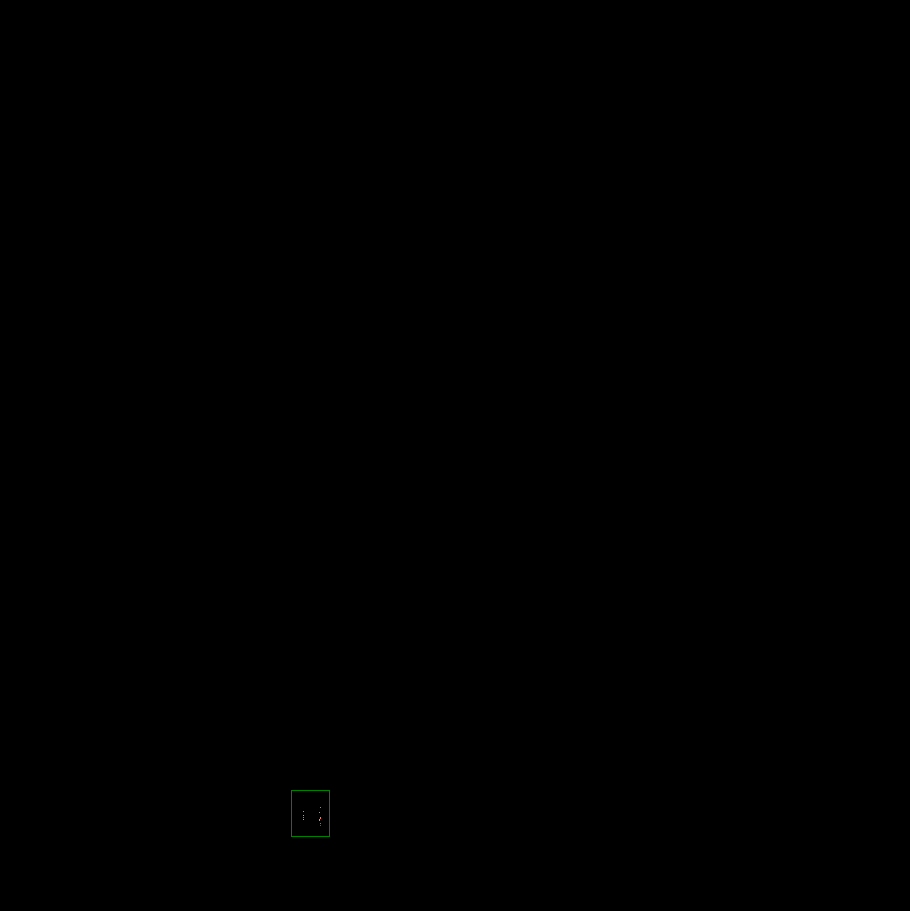

In [27]:
tile_img

Display the number of class instances in each set

In [28]:
SETS_BASE_DIR = '{}/sets'.format(TRAINING_SET_BASE_DIR)
TRAIN_SET_DIR = '{}/train'.format(SETS_BASE_DIR)
VAL_SET_DIR = '{}/validation'.format(SETS_BASE_DIR)
TEST_SET_DIR = '{}/test'.format(SETS_BASE_DIR)

In [29]:
sets = [TRAIN_SET_DIR, VAL_SET_DIR, TEST_SET_DIR]

In [30]:
for s in sets:
    # count the instances for each class in the train set
    instances_l = []
    training_set_txt_files = glob.glob("{}/*.txt".format(s))
    for fname in training_set_txt_files:
        df = pd.read_csv(fname, names=['instance_class','x','y','w','h'], sep=' ', header=None)
        instances_l.append(df)
    instances_df = pd.concat(instances_l, axis=0, sort=False)
    print("instances of each class in {}:\n{}\n".format(s, instances_df.instance_class.value_counts().to_string()))

instances of each class in /Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/train:
0    12980
1     2242

instances of each class in /Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/validation:
0    115
1      4

instances of each class in /Users/darylwilding-mcbride/Documents/Personal/PhD/source/yolo-tile-labelling/training set/sets/test:
0    127
1      8

